In [8]:
SAVE = False

Combine relevant evaluation files into a single file

In [ ]:
import sys
sys.path.append('..')
import os
import pandas as pd
import eval_reallabor_utils
import data_utils

MRT = [2, 3]
combined_eval_file = []

for mrt in MRT:

    results_dirs = [
        # f'v3_MRT{mrt}_SimpleModels_every_day/00_summary_7stepsahead_interv',
        # f'v3_MRT{mrt}_Kalman_every_day/00_summary_7stepsahead_interv',
        f'v3_MRT{mrt}_every_day/00_summary_7stepsahead_interv',
        # f'v3_MRT{mrt}_Transformer_every_day/00_summary_7stepsahead_interv'
        # f'v3_MRT{mrt}_Kalman_every_day/00_summary_7stepsahead_buggy',
        # f'v3_MRT{mrt}_every_day/00_summary_7stepsahead_buggy',
        # f'v3_MRT{mrt}_Transformer_every_day/00_summary_7stepsahead_buggy'
        f'v3_MRT{mrt}_SimpleModels_every_day/00_summary_31stepsahead',
        # f'v3_MRT{mrt}_every_day/00_summary_31stepsahead',
        f'v3_MRT{mrt}_Transformer_every_day/00_summary_31stepsahead',
        f'v3_MRT{mrt}_PF/00_summary_ensemble'
        f'v3_MRT{mrt}_Transformer_every_valid_day_seq_len_7/00_summary_7stepsahead_interv'
        ]

    eval_files = []
    for rd in results_dirs:
        eval_files.append(data_utils.join_ordinal_bptt_path('results', rd, 'evaluation.csv'))
        assert os.path.exists(eval_files[-1]), f'File {eval_files[-1]} does not exist!'
    eval_reallabor_utils.clear_line_and_print(f'Combining evaluation files')
    mrt_combined_eval_file = eval_reallabor_utils.combine_evaluation_files(eval_files, save_path=None, specifier_name='latent_model')
    mrt_combined_eval_file['MRT'] = mrt

    use_days_from_file = data_utils.train_test_split_path(mrt, 'valid_first_alarms_no_con_smoothed.csv')
    valid_days = pd.read_csv(use_days_from_file, index_col=0)
    valid_days.columns = [int(c) for c in valid_days.columns]

    eval_reallabor_utils.clear_line_and_print(f'Filtering out invalid days')
    eval_only_valid_days = []
    for p, group in mrt_combined_eval_file.groupby('participant'):
        if p in valid_days.columns:
            eval_only_valid_days.append(group.loc[group['test_day'].isin(valid_days[p])])
    mrt_combined_eval_file = pd.concat(eval_only_valid_days, axis=0, ignore_index=True)
    
    mrt_combined_eval_file['prediction'] = mrt_combined_eval_file['prediction'].clip(0, 8)

    combined_eval_file.append(mrt_combined_eval_file)

eval_reallabor_utils.clear_line_and_print(f'Creating grand combined evaluation file')
combined_eval_file = pd.concat(combined_eval_file, axis=0, ignore_index=False)
if not os.path.exists(data_utils.join_ordinal_bptt_path('results/_paper/combined_every_day_ensemble.csv')):
    os.makedirs(data_utils.join_ordinal_bptt_path('results/_paper'), exist_ok=True)
    combined_eval_file.to_csv(data_utils.join_ordinal_bptt_path('results/_paper/combined_every_day_ensemble.csv'))

Creating grand combined evaluation file                                                                                                                                                                 

In [30]:
combined_eval_file = eval_reallabor_utils.include_exclude_hypers(combined_eval_file, include_hyper={'steps':list(range(15))}, exclude_hyper={})

Generate bootstrap samples for metrics CI calculation, calculate metrics and CIs

In [10]:
from eval_reallabor import reallabor_metrics
m_manager = reallabor_metrics.MetricsManager(combined_eval_file, ['MRT', 'latent_model', 'steps'])

/export/home/jfechtel/miniconda3/envs/reallaborai4u/lib/python3.13/site-packages/pandas/core/frame.py:11211: RuntimeWarning: Degrees of freedom <= 0 for slice
  base_cov = np.cov(mat.T, ddof=ddof)
/export/home/jfechtel/miniconda3/envs/reallaborai4u/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:2914: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/export/home/jfechtel/miniconda3/envs/reallaborai4u/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:2914: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/export/home/jfechtel/miniconda3/envs/reallaborai4u/lib/python3.13/site-packages/pandas/core/frame.py:11211: RuntimeWarning: Degrees of freedom <= 0 for slice
  base_cov = np.cov(mat.T, ddof=ddof)
/export/home/jfechtel/miniconda3/envs/reallaborai4u/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:2914: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1,

In [ ]:
metrics, errorbars = {}, {}
metrics['mae'] = m_manager.mae(func='mean')
errorbars['mae'] = m_manager.mae(func='sem')

Plot stepwise MAE

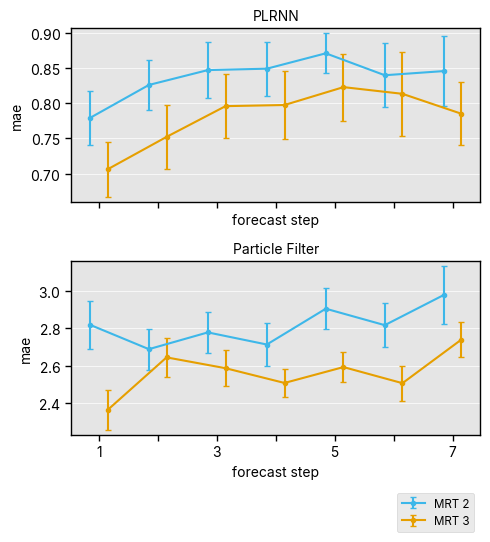

In [12]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from plotting_styles import PaperStyle
from plotting_utils import adjust_ylim

model_labels = {
                    # 'MovingAverage(1)': 'Last Step', 'MeanPredictor': 'Global Mean', 'InputsRegression': 'Linear Regression', 
                    # 'VAR1': 'VAR(1)', 
                    # 'KalmanFilter': 'Kalman Filter', 
                    'clipped-shallow-PLRNN': 'PLRNN', 
                    # 'hierarchized-clipped-shallow-PLRNN': 'H-PLRNN',
                    # 'Transformer': 'Transformer'
                    'pf_plrnn': 'Particle Filter'
                    }

with PaperStyle():

    color_cycle = ["#3DB7E9", "#e69f00"]
    offset = [-0.15, 0.15]

    fig, axes = plt.subplots(len(model_labels), len(metrics), figsize=(len(metrics)*4+1, len(model_labels)*2+1), sharex=True,squeeze=False)
    for i, m in enumerate(metrics):
        for l, model in enumerate(model_labels.keys()):
            for k, mrt in enumerate(MRT):            
                this_line = metrics[m].loc[mrt].loc[model]
                this_errorbars = errorbars[m].loc[mrt].loc[model].T
                axes[l, i].errorbar(this_line.index+offset[k], this_line, yerr=this_errorbars, linestyle='-', marker='.', label=f'MRT {mrt}')

            xticklabels = ['']*(len(this_line.index)-1)
            xticklabels[0::len(xticklabels)//3] = this_line.index[1::len(xticklabels)//3].astype(int)

            axes[l, i].set(xticks=this_line.index[1:], xticklabels=xticklabels, xlabel='forecast step', ylabel=m, title=model_labels[model])
            adjust_ylim(axes[l, i], 0.03, 0.03)
    plt.tight_layout()
    axes[-1, -1].legend(bbox_to_anchor=(1, -0.3))
    if SAVE:
        plt.savefig('../results/_paper/model_comparison/model_comparison_every_day_ensemble_stepwise.svg', dpi=300)
    plt.show()

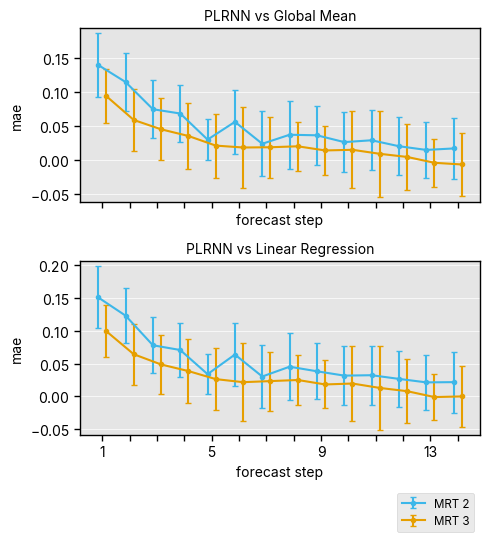

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from plotting_styles import PaperStyle
from plotting_utils import adjust_ylim

comparison_model_labels = {
                    'MeanPredictor': 'Global Mean', 'InputsRegression': 'Linear Regression', 
                    # 'VAR1': 'VAR(1)', 
                    # 'KalmanFilter': 'Kalman Filter', 
                    'Transformer': 'Transformer'
                    }

with PaperStyle():

    color_cycle = ["#3DB7E9", "#e69f00"]
    offset = [-0.15, 0.15]

    fig, axes = plt.subplots(len(comparison_model_labels), len(metrics), figsize=(len(metrics)*4+1, len(comparison_model_labels)*2+1), sharex=True,squeeze=False)
    for i, m in enumerate(metrics):
        for l, model in enumerate(comparison_model_labels.keys()):
            for k, mrt in enumerate(MRT):            
                this_line = metrics[m].loc[mrt].loc[model] - metrics[m].loc[mrt].loc['clipped-shallow-PLRNN']
                this_errorbars = errorbars[m].loc[mrt].loc[model].T
                axes[l, i].errorbar(this_line.index+offset[k], this_line, yerr=this_errorbars, linestyle='-', marker='.', label=f'MRT {mrt}')

            xticklabels = ['']*(len(this_line.index)-1)
            xticklabels[0::len(xticklabels)//3] = this_line.index[1::len(xticklabels)//3].astype(int)

            axes[l, i].set(xticks=this_line.index[1:], xticklabels=xticklabels, xlabel='forecast step', ylabel=m, title=f'PLRNN vs {comparison_model_labels[model]}')
            adjust_ylim(axes[l, i], 0.03, 0.03)
    plt.tight_layout()
    axes[-1, -1].legend(bbox_to_anchor=(1, -0.3))
    if SAVE:
        plt.savefig('../results/_paper/model_comparison/model_comparison_every_day_ensemble_stepwise.svg', dpi=300)
    plt.show()